In [1]:
import tensorflow as tf

In [19]:
from google.colab import drive
drive.mount('/content/drive')


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print(tf.config.experimental.list_logical_devices('GPU'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num GPUs Available:  1
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


# Model Defination

## Layer Defination

In [3]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Encoder, self).__init__()
    
    self.sep1 = tf.keras.layers.SeparableConv2D(int(filters / 4), [5,5], strides=[1,1], padding='same', activation='relu')
    self.sep2 = tf.keras.layers.SeparableConv2D(filters, [5,5], strides=[1,1], padding='same')

  def call(self, input):
    output = self.sep1(input)
    output = self.sep2(output)

    return output + input

class Downsample(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Downsample, self).__init__()

    self.sep1 = tf.keras.layers.SeparableConv2D(int(filters / 4), [5,5], strides=[2,2], padding='same', activation='relu')
    self.sep2 = tf.keras.layers.SeparableConv2D(filters, [5,5], strides=[1,1], padding='same')
    self.sep3 = tf.keras.layers.SeparableConv2D(filters, [3,3], strides=[2,2], padding='same')
  
  def call(self, input):
    out1 = self.sep1(input)
    out1 = self.sep2(out1)

    out2 = self.sep3(input)
    
    return out1 + out2

class Decoder(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Decoder, self).__init__()

    self.sep1 = tf.keras.layers.SeparableConv2D(filters, [3,3], strides=[1,1], padding='same', activation='relu')
    self.sep2 = tf.keras.layers.SeparableConv2D(filters, [3,3], strides=[1,1], padding='same')

  def call (self, input):
    out1 = self.sep1(input)
    out1 = self.sep2(out1)

    return out1 + input

class Upsample(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(Upsample, self).__init__()
    self.deconv = tf.keras.layers.Conv2DTranspose(filters, (3,3), strides=2, padding='same')

  def call (self, input):
    output = self.deconv(input)

    return output  

## Model Defination

In [4]:
class DenoiseNetwork(tf.keras.Model):
  def __init__(self):
    super(DenoiseNetwork, self).__init__()

    # Input stage
    self.input_stage = tf.keras.layers.Conv2D(16, (3,3), padding="same", input_shape=(160, 120, 1))

    # Encoder Stage 1
    self.encoder_stage1 = tf.keras.Sequential([
        Downsample(64),
        Encoder(64)                       
    ])

    # Encoder Stage 2
    self.encoder_stage2 = tf.keras.Sequential([
        Downsample(128),
        Encoder(128)                       
    ])

    # Encoder Stage 3
    self.encoder_stage3 = tf.keras.Sequential([
        Downsample(256),
        Encoder(256),
        Encoder(256),
        Encoder(256)                      
    ])

    # Encoder Stage 4
    self.encoder_stage4 = tf.keras.Sequential([
        Downsample(512),
        Encoder(512),
        Encoder(512),
        Encoder(512)                      
    ])

    # Decoder Stage 1
    self.decoder_stage1 = tf.keras.Sequential([
        Decoder(512),
        Upsample(64)
    ])

    # Decoder Stage 2
    self.decoder_stage2 = tf.keras.Sequential([
        Decoder(64),
        Upsample(32)
    ])
    # Decoder Stage 3
    self.decoder_stage3 = tf.keras.Sequential([
        Decoder(32),
        Upsample(32)
    ])
    # Decoder Stage 4
    self.decoder_stage4 = tf.keras.Sequential([
        Decoder(32),
        Upsample(16)
    ])

    # Separatable Convolution
    self.sep1 = tf.keras.layers.SeparableConv2D(16, (3,3), padding='same')
    self.sep2 = tf.keras.layers.SeparableConv2D(32, (3,3), padding='same')
    self.sep3 = tf.keras.layers.SeparableConv2D(32, (3,3), padding='same')
    self.sep4 = tf.keras.layers.SeparableConv2D(64, (3,3), padding='same')

    # Output Stage
    self.output_stage = tf.keras.Sequential([
        Decoder(16),
        tf.keras.layers.Conv2D(1, kernel_size=(3,3), padding='same')
    ])

  def call(self, input):

    out_i = self.input_stage(input)
    out_e1 = self.encoder_stage1(out_i)
    out_e2 = self.encoder_stage2(out_e1)
    out_e3 = self.encoder_stage3(out_e2)
    out_e4 = self.encoder_stage4(out_e3)

    out_d1 = self.decoder_stage1(out_e4) + self.sep4(out_e3)
    out_d2 = self.decoder_stage2(out_d1) + self.sep3(out_e2)
    out_d3 = self.decoder_stage3(out_d2) + self.sep2(out_e1)
    out_d4 = self.decoder_stage4(out_d3) + self.sep1(out_i)
    output = self.output_stage(out_d4) + input

    return output

## Create and Buil Model

In [5]:
model = DenoiseNetwork()
model.build((None, 160, 120, 1))
len(model.weights)

138

# Loss Function

In [6]:
def loss_function(y_ground_truth, y_pred):
  return tf.reduce_sum(tf.reduce_mean(tf.abs(y_pred - y_ground_truth), axis=0))

# Training Steps

In [7]:
# Custom training step
def train_step(model, optimizer, clean_img, noisy_img):

  variables = model.variables
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    
    tape.watch(variables)
    y_pred = model(noisy_img)
    loss = loss_function(clean_img, y_pred)

  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))

  return loss

In [ ]:
import sys

# Progress bar function
def progress(epoch, batch, total_batches, trained_samples, total_samples, current_loss, avg_loss, learning_rate, bar_length=30, time_elapsed=0, message=""):
    # Calculate progress percentage
    percent = float(trained_samples) / float(total_samples)
    
    # Create progress bar
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))

    # Estimate time remaining
    if time_elapsed > 0 and percent > 0:
        time_per_sample = time_elapsed / trained_samples
        remaining_time = time_per_sample * (total_samples - trained_samples)
        time_remaining = f"{int(remaining_time // 60)}m {int(remaining_time % 60)}s"
    else:
        time_remaining = "Calculating..."

    # Progress bar display
    sys.stdout.write(
        f"\rEpoch {epoch} [{batch}/{total_batches}] [{hashes}{spaces}] {int(percent * 100)}% "
        f"Loss: {current_loss:.4f} / Avg Loss: {avg_loss:.4f} | "
        f"LR: {learning_rate:.6f} | ETA: {time_remaining} {message}"
    )
    sys.stdout.flush()

In [ ]:
import tensorflow as tf
import time

def fit(model, lr, clean_imgs, noisy_imgs, epochs, validation_data=None, verbose=1):
    history = {
        'train_loss': [],
        'val_loss': [] if validation_data else None
    }

    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(lr)

    # Prepare dataset
    dataset = tf.data.Dataset.zip((clean_imgs, noisy_imgs))

    # Validation dataset (optional)
    val_dataset = None
    if validation_data:
        val_clean_imgs, val_noisy_imgs = validation_data
        val_dataset = tf.data.Dataset.zip((val_clean_imgs, val_noisy_imgs))

    # Training loop
    for e in range(epochs):
        total_loss = 0.0
        num_batches = 0
        start_time = time.time()

        # Iterate over batches
        for ite, (clean_img_batch, noisy_img_batch) in enumerate(dataset):
            batch_start_time = time.time()
            loss = train_step(model, optimizer, clean_img_batch, noisy_img_batch)
            total_loss += loss
            num_batches += 1

            avg_loss = total_loss / num_batches
            trained_samples = (ite + 1) * clean_img_batch.shape[0]
            total_samples = len(clean_imgs)

            # Display progress only if verbose is 1
            if verbose == 1:
                progress(
                    epoch=e+1,
                    batch=ite+1,
                    total_batches=len(dataset),
                    trained_samples=trained_samples,
                    total_samples=total_samples,
                    current_loss=float(loss),
                    avg_loss=float(avg_loss),
                    learning_rate=optimizer.learning_rate.numpy(),
                    bar_length=30,
                    time_elapsed=(time.time() - start_time)
                )

            # Delay to simulate time taken per batch (optional)
            time.sleep(0.01)

        avg_loss = total_loss / num_batches
        history['train_loss'].append(float(avg_loss))

        if verbose >= 1:
            print(f"\nEpoch {e+1}: --- Avg Train Loss: {avg_loss:.4f}")

        # Validation step (if validation data is provided)
        if val_dataset:
            val_loss = 0.0
            val_batches = 0
            for val_clean_batch, val_noisy_batch in val_dataset:
                y_val_pred = model(val_noisy_batch, training=False)
                val_loss += loss_function(val_clean_batch, y_val_pred)
                val_batches += 1

            avg_val_loss = val_loss / val_batches
            history['val_loss'].append(float(avg_val_loss))

            if verbose >= 1:
                print(f"Epoch {e+1}: --- Avg Validation Loss: {avg_val_loss:.4f}")

    return history

# Load Data

In [ ]:
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the zip file
zip_file_path = '/content/drive/My Drive/Data/FLIR_Thermal_Images_Dataset.zip'
# Define the directory to extract the files to
extract_dir = '/content/FLIR_Thermal_Images_Dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

# Define the path for training, validation and test data
train_clean_path = '/content/FLIR_Thermal_Images_Dataset/FLIR/Train/Clean'
train_noisy_path = '/content/FLIR_Thermal_Images_Dataset/FLIR/Train/Noisy'

val_clean_path = '/content/FLIR_Thermal_Images_Dataset/FLIR/Validation/Clean'
val_noisy_path = '/content/FLIR_Thermal_Images_Dataset/FLIR/Validation/Noisy'

test_clean_path = '/content/FLIR_Thermal_Images_Dataset/FLIR/Test/Clean'
test_noisy_path = '/content/FLIR_Thermal_Images_Dataset/FLIR/Test/Noisy'

# load the images
def load_images(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, channels=1)
  img = tf.cast(img, tf.float32) / 255.0

# Batch size
BATCH_SIZE = 8

# Create two datasets from images
def create_dataset(clean_path, noisy_path, batch_size):
  clean_files = tf.data.Dataset.list_files(clean_path + '/*.png', shuffle=False)
  noisy_files = tf.data.Dataset.list_files(noisy_path + '/*.png', shuffle=False)

  clean_dataset = clean_files.map(lambda x: load_images(x)).batch(batch_size)
  noisy_dataset = noisy_files.map(lambda x: load_images(x)).batch(batch_size)

  return clean_dataset, noisy_dataset

# Create datasets for training, validation and test
train_clean_imgs, train_noisy_imgs = create_dataset(train_clean_path, train_noisy_path, BATCH_SIZE)
val_clean_imgs, val_noisy_imgs = create_dataset(val_clean_path, val_noisy_path, BATCH_SIZE)
test_clean_imgs, test_noisy_imgs = create_dataset(test_clean_path, test_noisy_path, BATCH_SIZE)

print("Training Clean Images: ", len(train_clean_imgs))
print("Training Noisy Images: ", len(train_noisy_imgs))
print("Validation Clean Images: ", len(val_clean_imgs))
print("Validation Noisy Images: ", len(val_noisy_imgs))
print("Test Clean Images: ", len(test_clean_imgs))
print("Test Noisy Images: ", len(test_noisy_imgs))


## Train with first 30 epochs 

In [ ]:
history = fit(
    model=model,
    lr=1e-3,
    clean_imgs=train_clean_imgs,
    noisy_imgs=train_noisy_imgs,
    epochs=30,
    validation_data=(val_clean_imgs, val_noisy_imgs),  # Optional validation data
    verbose=1  # Progress bar
)

Epoch 1: [#########################] 100%  ----- Loss: 6180.927734375
 Epoch 1: --- Avg Loss: 6680.73388671875
Epoch 2: [#########################] 100%  ----- Loss: 6098.9521484375
 Epoch 2: --- Avg Loss: 4344.837890625
Epoch 3: [#########################] 100%  ----- Loss: 6162.5419921875
 Epoch 3: --- Avg Loss: 4040.492919921875
Epoch 4: [#########################] 100%  ----- Loss: 6165.201171875
 Epoch 4: --- Avg Loss: 3856.072509765625
Epoch 5: [#########################] 100%  ----- Loss: 6453.93896484375
 Epoch 5: --- Avg Loss: 3674.99267578125
Epoch 6: [#########################] 100%  ----- Loss: 6257.0380859375
 Epoch 6: --- Avg Loss: 3601.1455078125
Epoch 7: [#########################] 100%  ----- Loss: 5604.1357421875
 Epoch 7: --- Avg Loss: 3342.703857421875
Epoch 8: [#########################] 100%  ----- Loss: 5400.5791015625
 Epoch 8: --- Avg Loss: 3162.960693359375
Epoch 9: [#########################] 100%  ----- Loss: 5147.63134765625
 Epoch 9: --- Avg Loss: 3018.811

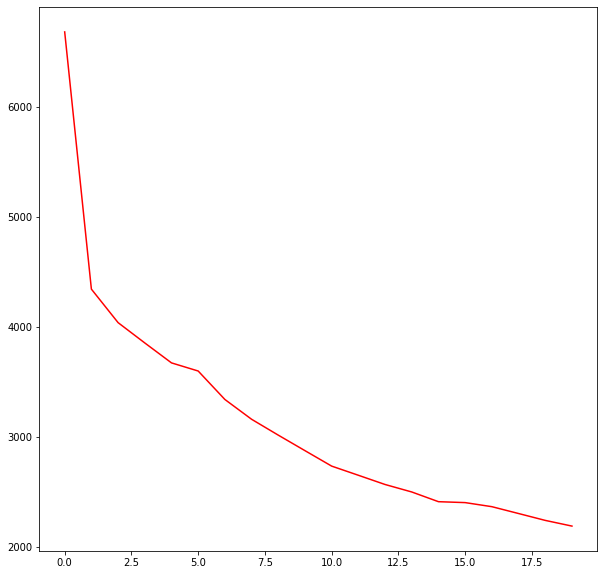

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(epochs, history['train_loss'], 'r-', label='Training Loss', marker='o')

    # If validation loss exists, plot it
    if 'val_loss' in history:
        plt.plot(epochs, history['val_loss'], 'b-', label='Validation Loss', marker='x')

    # Add title and labels
    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    # Add grid for better readability
    plt.grid(True)

    # Add legend
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

plot_history(history)

# Inference

# Save Model

In [11]:
# Save the entir model as a TensorFlow SavedModel
# This will save weights and architecture
model.save('/content/drive/My Drive/Models/pmrid')

# TensorFlow Lite For Deployment

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/My Drive/Models/pmrid')
tflite_model = converter.convert()

# Save the model as a .tflite file
with open('/content/drive/My Drive/Models/pmrid.tflite', 'wb') as f:
  f.write(tflite_model)